In [1]:
import os
import sys

import math
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
import torchvision.models as models

from torchviz import make_dot
import matplotlib.pyplot as plt
import graphviz

from pathlib import Path
from userHelper import *


# Model Specifics
# import pytorch_resnet as R
import BaseModel as B
import CDDSM
from tqdm import tqdm



#Device Selection
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 5
num_classes = 3
batch_size = 4
learning_rate = 0.001

def pause(strg):
    if(strg!=''):
        print('Reached at {}, Press any key to continue'.format(strg))
    else:
        print('Paused, Press any to continue')
    input()
    return

# x = torch.randn(batch_size, channels_mammo,heights_mammo , width_mammo)

# Reading Standard CSV files by TCIA for test/train

In [2]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device ='cpu'
num_epochs = 100
num_classes = 3
batch_size = 2
learning_rate = 0.0001

total_iteration = 10000
img_resize =H=W=512


homedir = str(Path.home())
homedir

train_df = CDDSM.createTrainFrame(homedir)
test_df = CDDSM.createTestFrame(homedir)
mammogram_dir = '/home/himanshu/CuratedDDSM/'
train_file = mammogram_dir+'train.csv'
test_file = mammogram_dir+'test.csv'
train_df.to_csv(train_file)
test_df.to_csv(test_file)

classes = ('BENIGN', 'BENIGN_WITHOUT_CALLBACK', 'MALIGNANT')
                

# Making of CBIS-DDSM Dataset (train,val,test)

In [3]:
dataset =  CDDSM.MammographyDataset(train_file,homedir,img_resize)
test_dataset = CDDSM.MammographyDataset(test_file,homedir,img_resize)

train_dataset , val_dataset = CDDSM.trainValSplit(dataset,val_share=0.98)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

# Length of each Dataset

In [4]:
numberOfTrainData = train_dataset.__len__()
numberOfValData = val_dataset.__len__()
numberOfTestData =  test_dataset.__len__()

total_step=len(train_loader)

print('Size of training dataset {}'.format(numberOfTrainData))
print('Size of Validation dataset {}'.format(numberOfValData))
print('Size of testing dataset {}'.format(numberOfTestData))
print('No. of Epochs: {}\n Batch size: {}\n Learning_rate : {}\n Image size {}*{}\n Step {}'
        .format(num_epochs,batch_size,learning_rate,H,W,total_step))

Size of training dataset 57
Size of Validation dataset 2807
Size of testing dataset 704
No. of Epochs: 100
 Batch size: 2
 Learning_rate : 0.0001
 Image size 512*512
 Step 29


# Checking images in each dataset by making grid

# trainDataset

MALIGNANT BENIGN


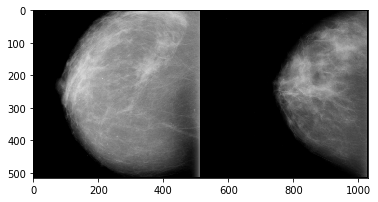

In [5]:
trainloader = train_loader
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

# val Dataset

BENIGN BENIGN_WITHOUT_CALLBACK


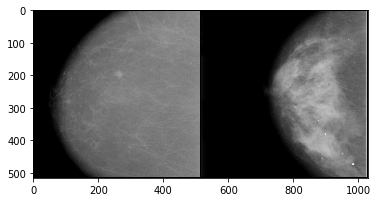

In [6]:
trainloader = val_loader
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

# test Dataset

MALIGNANT MALIGNANT


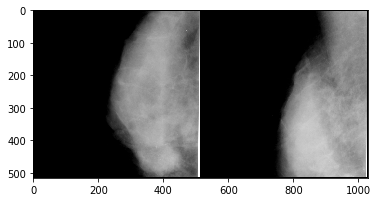

In [7]:
trainloader = test_loader
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

# Get Model

In [249]:
import torchvision.models as models
resnet18 = models.resnet18(pretrained=True)


# removing last layer of resnet

resnet18 = nn.Sequential(*list(resnet18.children())[:-1])


class myCustomModel(torch.nn.Module):
    def __init__(self,pretrainedModel):
        super(myCustomModel,self).__init__()
        
        self.layer0 = nn.Sequential()
        self.layer0.add_module('conv0',nn.Conv2d(1,3,kernel_size=9,stride=1,padding=0,dilation=8))
        self.layer0.add_module('relu0',nn.ReLU())
        self.layer0.add_module('maxpool',nn.MaxPool2d(kernel_size=2))
        self.layer1 = nn.Sequential()
        self.layer1.add_module('pretrained',pretrainedModel)
        self.fc = nn.Linear(in_features=512,out_features=3)
    def forward(self,x):
        x = self.layer0(x)
        features = self.layer1(x)
        features = features.view(features.size(0), -1)
        x =  self.fc(features)
        return features , x

def getCustomPretrained(model):
    return myCustomModel(model)

for param in resnet18.parameters():
    param.requires_grad = False
    
    
# parameters with parameters requires grad is True
# for p in resnet18.parameters():
#     print(p.requires_grad)

# model = B.getModel(3).to(device)
model=getCustomPretrained(resnet18)



# for p in model.parameters():
#     print(p.requires_grad)
# print(model)

# store best prediction in one epoch

best_prec = 0


criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.1)

# x = torch.rand(15,1,512,512)

# f,out=model(x)

# print(out.size())
# print(f.size())
# fc =  nn.Linear(512,3)

In [250]:
# child_counter = 0
# for child in model.children():
#    print(" child", child_counter, "is:")
#    print(child)
#    child_counter += 1

In [251]:
# check = torch.rand(1,1,512,512)
# check=check+255

# for k in range(16):
#     for d in range(16):
#         value=(k-1)*d
#         if (value==64):
#             print("k={},d={}".format(k,d))

# conv = nn.Conv2d(in_channels=1,out_channels=3,kernel_size=9,stride=1,padding=0,dilation=8)

# out = conv(check)
# out.data

# params = list(conv.parameters())

# # figure something for this init kernel with gaussian filters
# # params[0].size() =

# img=out.detach().numpy()
# img.shape=(448,448,3)
# plt.imshow(img,cmap='gray')

# conv?



In [140]:
# See the architecture
# print(model)
model = getCustomPretrained(resnet18)

In [141]:
print(model)

myCustomModel(
  (layer0): Sequential(
    (conv0): Conv2d(1, 3, kernel_size=(9, 9), stride=(1, 1), dilation=(8, 8))
    (relu0): ReLU()
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (pretrained): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1

In [142]:
print(criterion)

CrossEntropyLoss()


In [13]:
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)


# TensorBoard Logger

In [14]:
from tensorboardX import SummaryWriter
writer = SummaryWriter('runs',comment="baseline")

In [15]:
def save_checkpoint(state,is_best,filename='./models/checkpoint.pth.tar'):
        torch.save(state,filename)
        if is_best:
            shutil.copyfile(filename,'./models/model_best.pth.tar')

In [16]:
def train(train_loader,model,criterion,optimizer,epoch,writer):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    avgaccu =  AverageMeter()
    
    model.train()
    
    end = time.time()
    for i,(images,labels) in enumerate(train_loader):
        data_time.update(time.time()-end)
        images = images.to(device)
        labels = labels.to(device)
        
        output = model(images)
        loss = criterion(output,labels)
        
        # top-k ? accuaracy 
        # for now evaluating normal accuracy
        acc = accuracy(output,labels)
        
        #loss.item() to get the loss value from loss tensor
        losses.update(loss.item(), images.size(0))
        avgaccu.update(acc,images.size(0))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_time.update(time.time() - end)
        end = time.time()

        print('Epoch: [{0}][{1}/{2}]\t'
              'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
              'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
              'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
              'Accuracy {acc.val:.4f} ({acc.avg:.4f})\t'.format(
               epoch, i, len(train_loader), batch_time=batch_time,
               data_time=data_time, loss=losses, acc=avgaccu))

In [17]:
def validate(val_loader, model, criterion):
    batch_time = AverageMeter()
    losses = AverageMeter()
    avgaccu =  AverageMeter()

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(val_loader):
            input=input.to(device)
            target =  target.to(device)
            
            # compute output
            output = model(input)
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc= accuracy(output, target)
            losses.update(loss.item(), input.size(0))
            avgaccu.update(acc,input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Acc {acc.val:.3f} ({acc.avg:.3f})'.format(
                   i, len(val_loader), batch_time=batch_time, loss=losses,acc=avgaccu))

        print(' * Acc {acc.avg:.3f}'
              .format(acc=avgaccu))

    return acc

In [18]:
def accuracy(output,target):
    with torch.no_grad():
        batch_size =  target.size(0)
        _, predicted = torch.max(output.data, 1)
        total = target.size(0)
        correct = (predicted == target).sum().item()
        acc = correct/total
#         print(correct)
#         print(total)
#         print(predicted)
#         print(target)
#         print(output)
        
#         pause('accuracy')
    return acc

In [19]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

# Training

In [20]:

log_freq=10
for epoch in range(num_epochs):
    
    adjust_learning_rate(optimizer,epoch,learning_rate)
    
    
    train(train_loader,model,criterion,optimizer,epoch,writer)
    
    acc =  validate(val_loader,model,criterion)
    
    is_best = acc > best_acc
    
    best_acc = max(acc,best_acc)
    
    #saving the checkpoint if is_best is True
    save_checkpoint({
        'epoch':epoch+1,
        'state_dict':model.state_dict(),
        'best_acc':best_acc,
        'optimizer':optimizer.state_dict(),
    },is_best)

RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[2, 1, 512, 512] to have 3 channels, but got 1 channels instead

In [ ]:
# # # Reading a mammogram
# # homedir = str(Path.home())
# # homedir

# # # CSV preprocessing
# # train_df = CDDSM.createTrainFrame(homedir)
# # test_df = CDDSM.createTestFrame(homedir)
# # mammogram_dir = '/home/himanshu/CuratedDDSM/'
# # train_file = mammogram_dir+'train.csv'
# # test_file = mammogram_dir+'test.csv'
# # train_df.to_csv(train_file)
# # test_df.to_csv(test_file)

# # # labells = train_df[['pathology','pathology_class']]
# # # print(labells)


# # classes = ('BENIGN', 'BENIGN_WITHOUT_CALLBACK', 'MALIGNANT')

# # # Mammography dataset
# # train_dataset =  CDDSM.MammographyDataset(train_file,homedir)
# # test_dataset = CDDSM.MammographyDataset(test_file,homedir)
# # # Data loader
# # train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
# #                                            batch_size=batch_size, 
# #                                            shuffle=True)

# # test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
# #                                           batch_size=batch_size, 
# #                                           shuffle=False)



# x = torch.randn(5,1,512 ,512)

# x.size()

# outputs =  model(images)

# dataiter = iter(trainloader)
# images, labels = dataiter.next()

# images.size()
# outputs = model(images)
# labels

# outputs.data

# labels

# outputs.type()

# outputs.softmax(1)

# # m = nn.Softmax()
# # o = m(outputs)
# # # 

# # criterion(outputs,labels)

# # m = nn.Softmax()
# # # input = torch.randn(2, 3)
# # print(input.type())

# # print(input)
# # output = m(input)
# # print(output.type())

# # _, predicted = torch.max(output.data, 1)

# # predicted



In [28]:
def test(test_loader,model):

    # Test the model
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Test Accuracy of the model on the 10000 test images: {} %'.format(100 * correct / total))


In [ ]:
# Loss Function

# loss function should be averaged summation of class loss (log loss)
# and normalized and weighted regression loss

output =  net(inputX)
groundTruth = torch.randn(10) #dummy target for now

groundTruth = groundTruth.view(1,-1)

groundTruth=groundTruth.reshape(1,10)

defineLossfn = nn.MSELoss()
loss = defineLossfn(output,groundTruth)

print(groundTruth.shape)
print(output.shape)
print(output.data)
print(groundTruth.data)
print(loss.data)

print(loss.grad_fn)
a =  loss.grad_fn
print(a.next_functions[0][0])
a = a.next_functions[0][0]
print(a.next_functions[0][0])
a = a.next_functions[0][0]
print(a.next_functions[0][0])

net.zero_grad() #zeroes the gradient buffers of all parameters
print(net.conv1.bias.grad)
print(net.conv2.bias.grad)
print(net.fc1.bias.grad)
print(net.fc2.bias.grad)
print(net.fc3.bias.grad)
for i in range(3):
    loss.backward(retain_graph=True,create_graph=True)
    print(net.conv1.bias.grad)
#     print(net.conv1.bias.grad)
#     print(net.conv2.bias.grad)
#     print(net.fc1.bias.grad)
#     print(net.fc2.bias.grad)
#     print(net.fc3.bias.grad)

for i in range(3):
    loss.backward(retain_graph=True,create_graph=True)
    print(net.conv1.bias.grad)

for i in range(3):
    loss.backward(retain_graph=True,create_graph=True)
    print(net.conv1.bias.grad)

# Updating the weights

In [ ]:
learning_rate = 0.01
for f in net.parameters():
    f.data.sub_(f.grad.data*learning_rate)

In [ ]:
# creating your optimizer
optimizer = optim.SGD(net.parameters(),lr=0.01)

# this should  be in training loop, how many iterations :
optimizer.zero_grad()
output = net(inputX)
loss = defineLossfn(output, groundTruth)
loss.backward()
optimizer.step()

In [ ]:
# #visualization  helper
# def vis_detections(im, dets, CONF_THRESH = 0.23):
#     """Draw boxes around detected cancer."""   
#     fig,ax=plt.subplots(figsize=(8,10))
#     ax.imshow(im,cmap='gray_r')
#     inds = np.where(dets[:, -1] >= CONF_THRESH)[0]
    
#     for i in inds:
#         bbox = dets[i, :4]
#         score = dets[i, -1]
#         ax.add_patch(
#             plt.Rectangle((bbox[0], bbox[1]),
#                           bbox[2] - bbox[0],
#                           bbox[3] - bbox[1], fill=False, linestyle ='dashed',
#                           edgecolor=(0.95, 0.95, 0.5), linewidth=3))
#     plt.axis('off')
#     plt.tight_layout()